In [22]:
import logging

# logging.basicConfig(
#     level=logging.DEBUG,
#     format='%(asctime)s - %(levelname)s - %(message)s'
# )

logger = logging.getLogger("dicris")
logger.setLevel(logging.DEBUG)

# Create handlers
console_handler = logging.StreamHandler()
file_handler = logging.FileHandler("dicris.log")

# Set levels for handlers
console_handler.setLevel(logging.DEBUG)
file_handler.setLevel(logging.DEBUG)

# Create formatters and add to handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
console_handler.setFormatter(formatter)
file_handler.setFormatter(formatter)

# Add handlers to logger
logger.addHandler(console_handler)
# logger.addHandler(file_handler)

import contextily as ctx
import geemap
import geocube
import geopandas as gpd
import io
import json
import keras
import laspy
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
import pandas as pd
import pathlib
import rasterio
import re
import seaborn as sns
import shapely
import spectral
import tempfile
import tensorflow as tf
import zipfile

from affine import Affine
from functools import partial
from geocube.api.core import make_geocube
from IPython.display import JSON, HTML
from keras.utils import to_categorical
from matplotlib.colors import to_rgba
from mpl_toolkits.mplot3d import Axes3D
from pyproj import CRS
from rasterio.io import MemoryFile
from shapely.affinity import affine_transform
from shapely.geometry import box, mapping, Point, Polygon
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from spectral import envi
from tensorflow.keras import layers
from tqdm.notebook import trange, tqdm

# Make numpy values easier to read.
np.set_printoptions(precision=6, suppress=True)

%matplotlib inline

In [49]:
def find_las_files(dir):
    files = [f for f in pathlib.Path(dir).rglob('*') if f.suffix.lower().endswith(('.las'))]
    files = sorted(files, key=lambda k: k.as_posix().lower())
    return files


def sample_las(las, p=0.3):
    """
    Randomly sample a fraction of points from a LAS point cloud.

    This function creates a new LAS object containing a random subset of points 
    from the input LAS data. The sampling is done without replacement.

    Parameters:
        las (laspy.LasData): Input LAS point cloud data.
        p (float, optional): Fraction of total points to sample (default is 0.3).

    Returns:
        laspy.LasData: A new LAS data object containing the sampled points.

    Raises:
        ValueError: If the fraction p is not in the range (0, 1].
    """
    total_points = len(las.points)
    n = int(p * total_points)
    indices = np.random.choice(total_points, size=n, replace=False)
    sampled_points = las.points[indices]
    new_las = laspy.LasData(las.header)
    new_las.points = sampled_points
    return new_las


def display_las(las, class_name='z', title=None):
    """
    Display LAS point cloud data in a 3D scatter plot.

    Parameters:
        las (laspy.LasData): LAS data object to visualize.
    """
    x = las.x
    y = las.y
    z = las.z
    c = las[class_name]

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x, y, z, c=c, cmap='viridis', s=0.1)

    # produce a legend with the unique colors from the scatter
    legend = ax.legend(
        *scatter.legend_elements(),
        loc="lower left",
        title=class_name
    )
    ax.add_artist(legend)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

## find .las files

In [3]:
data_dir = os.path.join('/tf/notebooks/data/Hyperspektral_data/HYSPED/')
las_files = find_las_files(data_dir)
logger.info(f'las files found: {len(las_files)}')

2025-05-29 11:15:47,359 - dicris - INFO - las files found: 50


## load selected .las file

In [4]:
las_file = las_files[0]
las = laspy.read(las_file)
logger.info(f'las.header.point_format: {las.header.point_format}')

2025-05-29 11:15:54,645 - dicris - INFO - las.header.point_format: <PointFormat(1, 0 bytes of extra dims)>


## randomly sample % points of the loaded .las file

In [24]:
las_sampled = sample_las(las, 0.05)

<LasData(1.2, point fmt: <PointFormat(1, 0 bytes of extra dims)>, 597816 points, 1 vlrs)>

## display sampled data

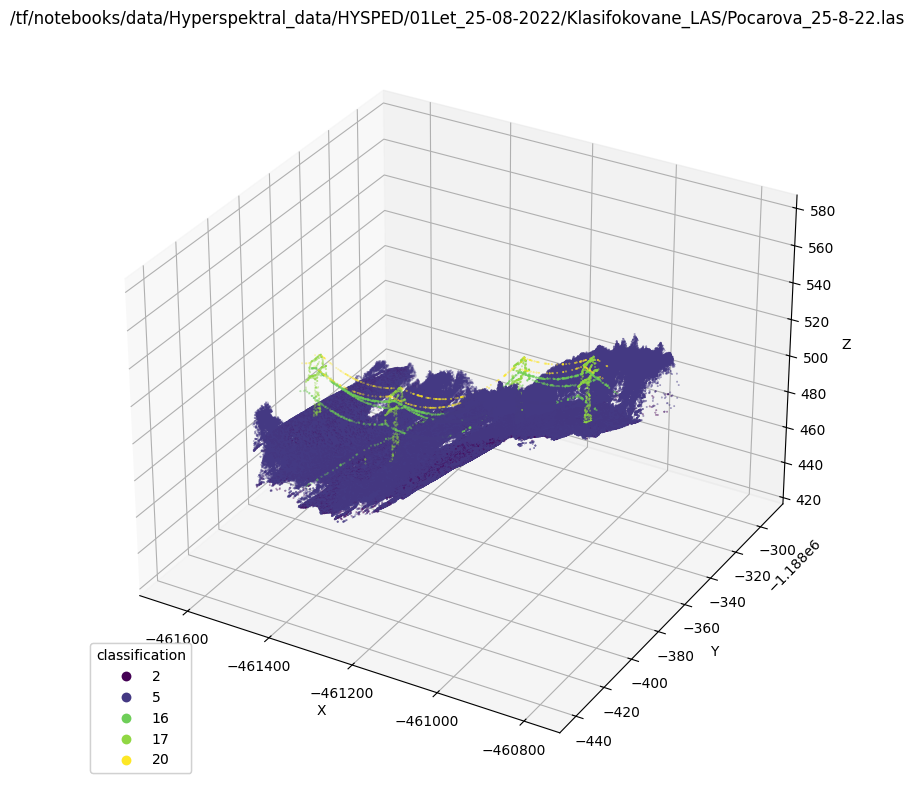

In [50]:
display_las(
    las_sampled,
    class_name='classification',
    title=las_file
)

## interactive 3D preview

In [ ]:
temp_f = tempfile.NamedTemporaryFile(mode='wb', delete=False, suffix='.las')
las_sampled.write(temp_f)
temp_f.close()
geemap.view_lidar(temp_f.file.name, backend='open3d')
os.remove(temp_f.file.name)